In [4]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

#IMAGE = "circle.jpg"
IMAGE = "lisa.png"
#IMAGE = "melita.png"
IMAGE = "ranveer.png"
INITIAL_POPULATION = 1000
EPOCHS = 400
DNA_LENGTH = 512
MUTATE_RATE = 10
RADIUS_MAX = 50
POPULATION_HEALTH_DIVISOR = 5
#IMG_COLOR = cv2.COLOR_BGR2RGB
IMG_COLOR = cv2.COLOR_BGR2GRAY


class Individual:
   ID_COUNT = 0
   def __init__(self, shape):
      self.dna = [] 
      self.shape = shape
      self.id = Individual.ID_COUNT
      Individual.ID_COUNT += 1

   def __str__(self):
      print(f"{self}, len is: #{len(self.dna)}")

   def init_dna(self):
      raise NotImplementedError()

   def generate_image_from_dna(self):
      raise NotImplementedError()

   def mutate_dna(self, child, i):
      pass

   def error_function(self, ref_image):
      # Float value of the difference between the two images
      return np.sum(np.abs(self.generate_image_from_dna().astype(float) - ref_image.astype(float)))

   def breed(self, other):
      child = self.__class__(self.shape)
      for i in range(len(self.dna)):
         if np.random.randint(0,2) == 0:
            child.dna.append(self.dna[i])
         else:
            child.dna.append(other.dna[i])
      # mutate
      for i in range(len(child.dna)):
         if np.random.randint(0,MUTATE_RATE) == 0:
            self.mutate_dna(child, i)
      return child


class CircleIndividual(Individual):
   def __init__(self, shape):
      super().__init__(shape)

   def init_dna(self):
      # Random circles, store in DNA
      for i in range(DNA_LENGTH):
         center = (np.random.randint(0,self.shape[1]), np.random.randint(0,self.shape[0])) 
         radius = np.random.randint(1,RADIUS_MAX)
         color = (np.random.randint(0,255),np.random.randint(0,255),np.random.randint(0,255))
         self.dna.append((center,radius,color))

   def generate_image_from_dna(self):
      img = np.zeros((self.shape[0],self.shape[1],3), np.uint8)
      for i in range(len(self.dna)):
         cv2.circle(img,(self.dna[i][0][0],self.dna[i][0][1]),self.dna[i][1],self.dna[i][2],-1)
      return cv2.cvtColor(img, IMG_COLOR)

   def mutate_dna(self, child, i):
      child.dna[i] = (child.dna[i][0], np.random.randint(1,RADIUS_MAX), child.dna[i][2])
      center = (np.random.randint(0,self.shape[1]), np.random.randint(0,self.shape[0])) 
      child.dna[i] = (center, child.dna[i][1], child.dna[i][2])


class PolyIndividual(Individual):
   def __init__(self, shape):
      super().__init__(shape)

   def init_dna(self):
      # Random Polygons, store in DNA
      for i in range(DNA_LENGTH):
         points = []
         for j in range(3):
            points.append((np.random.randint(0,self.shape[1]/4), np.random.randint(0,self.shape[0]/4)))
         color = (np.random.randint(0,255),np.random.randint(0,255),np.random.randint(0,255))
         self.dna.append((points,color))

   def generate_image_from_dna(self):
      img = np.zeros((self.shape[0],self.shape[1],3), np.uint8)
      for i in range(len(self.dna)):
         cv2.fillConvexPoly(img, np.array(self.dna[i][0]), self.dna[i][1])
      return cv2.cvtColor(img, IMG_COLOR)

   def mutate_dna(self, child, i):
      # Mutate a childs point by an offset of 0.5
      points = []
      for j in range(3):
         points.append((child.dna[i][0][j][0] + np.random.randint(-int(self.shape[1]/2),int(self.shape[1]/2)), child.dna[i][0][j][1] + np.random.randint(-int(self.shape[0]/2),int(self.shape[0]/2))))
      child.dna[i] = (points, child.dna[i][1])


def get_top_n(pop, ref_image, n):
   # Sort by error
   pop.sort(key=lambda x: x.error_function(ref_image))
   return pop[:n]


In [5]:
ref_image = cv2.imread(IMAGE)
ref_image = cv2.cvtColor(ref_image, IMG_COLOR)
population = []
error_values = []
individual_count = 0

# Generate initial population
for n in range(0, INITIAL_POPULATION):
    #pop = PopPolygon(ref_image.shape)
    pop = CircleIndividual(ref_image.shape)
    pop.init_dna()
    population.append(pop)
first_best = get_top_n(population, ref_image, 1)[0]

for i in range(0, EPOCHS):
    top_list = get_top_n(population, ref_image, len(population))
    best_error = top_list[0].error_function(ref_image)
    error_values.append(best_error)

    print("Generation: " + str(i))
    print("Best: " + str(best_error))

    # Breed 1000 new population based on best
    population_new = []
    for n in range(0, INITIAL_POPULATION):
        try: 
            parent1 = top_list[np.random.randint(0,INITIAL_POPULATION/POPULATION_HEALTH_DIVISOR)]
            parent2 = top_list[np.random.randint(0,INITIAL_POPULATION/POPULATION_HEALTH_DIVISOR)]
            child = parent1.breed(parent2)
            population_new.append(child)
        except Exception as e:
            print(e)
            print(str(parent1))
            print(str(parent2))
            raise e

    population = population_new

top_list = get_top_n(population, ref_image, len(population))
best = top_list[0]
print(len(population))


Generation: 0
Best: 2936909.0
Generation: 1
Best: 2680101.0
Generation: 2
Best: 2622538.0
Generation: 3
Best: 2512009.0
Generation: 4
Best: 2359030.0
Generation: 5
Best: 2228146.0
Generation: 6
Best: 2184262.0
Generation: 7
Best: 2103051.0
Generation: 8
Best: 2029319.0
Generation: 9
Best: 1995373.0
Generation: 10
Best: 1905833.0
Generation: 11
Best: 1869439.0
Generation: 12
Best: 1819889.0
Generation: 13
Best: 1803002.0
Generation: 14
Best: 1721880.0
Generation: 15
Best: 1690942.0
Generation: 16
Best: 1684783.0
Generation: 17
Best: 1669971.0
Generation: 18
Best: 1565774.0
Generation: 19
Best: 1599418.0
Generation: 20
Best: 1546975.0
Generation: 21
Best: 1556736.0
Generation: 22
Best: 1549955.0
Generation: 23
Best: 1540863.0
Generation: 24
Best: 1507106.0
Generation: 25
Best: 1500210.0
Generation: 26
Best: 1503914.0
Generation: 27
Best: 1482587.0
Generation: 28
Best: 1486147.0
Generation: 29
Best: 1470198.0
Generation: 30
Best: 1464608.0
Generation: 31
Best: 1443118.0
Generation: 32
Bes

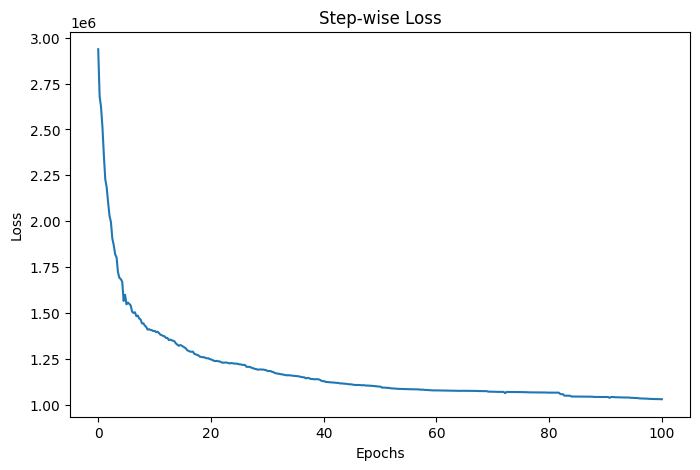

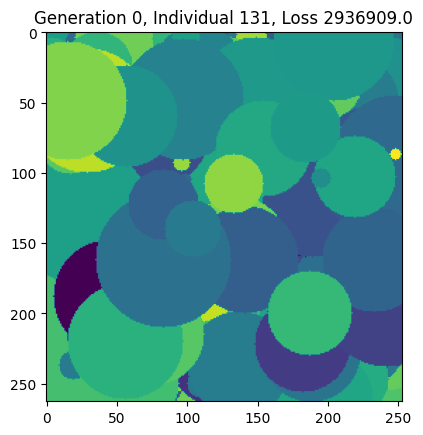

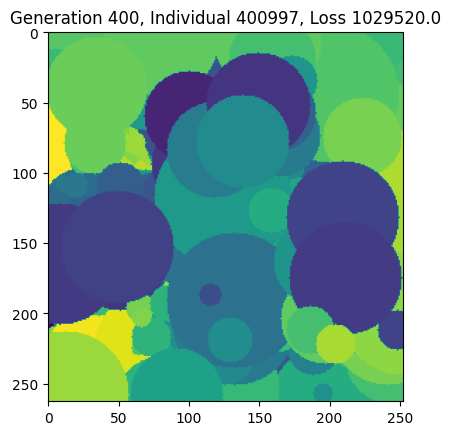

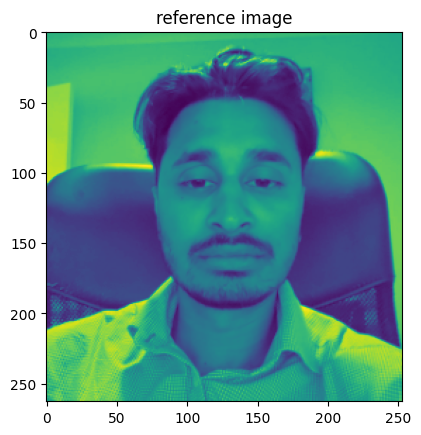

In [6]:
step = np.linspace(0, 100, EPOCHS)
fig, ax = plt.subplots(figsize=(8,5))
plt.plot(step, np.array((error_values)))
plt.title("Step-wise Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

plt.imshow(first_best.generate_image_from_dna())
plt.title(f'Generation 0, Individual {first_best.id}, Loss {first_best.error_function(ref_image)}')
plt.show()

plt.imshow(best.generate_image_from_dna())
plt.title(f'Generation {EPOCHS}, Individual {best.id}, Loss {best.error_function(ref_image)}')
plt.show()

plt.imshow(ref_image)
plt.title('reference image')
plt.show()
